# Play with the dataset

In [6]:
%load_ext autoreload
%autoreload 2

import os, numpy, glob, collections, random
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
%pylab inline

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Lambda, BatchNormalization, Dropout, Activation, concatenate
from keras.optimizers import RMSprop, Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'random', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Build some statistics

In [7]:
hist_bins = numpy.arange(0, 256, 10, dtype=numpy.uint8)
half_bins = hist_bins.shape[0] // 2
def get_image_stat(fname):
    img = Image.open(fname)
    pixels = numpy.asarray(img)
    return numpy.histogram(pixels, bins = hist_bins)[0]


def aggregate_stat_for_multiple_images(fnames):
    marginal_hist = numpy.zeros(hist_bins.shape[0] - 1,
                                dtype=numpy.float)
    number_of_white_images = 0
    img_cnt = 0.0
    for fname in fnames:
        cur_hist = get_image_stat(fname)
        marginal_hist += cur_hist
        img_cnt += 1
        if cur_hist[half_bins:].sum() > 0:
            number_of_white_images += 1
    return marginal_hist / img_cnt, number_of_white_images

def folder_stat(dirname):
    fig, (in_ax, out_ax) = plt.subplots(2)

    in_files = list(glob.glob(os.path.join(dirname, '*_in.png')))
    in_files_cnt = len(in_files)
    in_hist, in_white_cnt = aggregate_stat_for_multiple_images(in_files)
    in_ax.bar(hist_bins[:-1], in_hist, label='In')
    in_ax.legend()
    print(f'In white {in_white_cnt} / {in_files_cnt}')

    out_files = glob.glob(os.path.join(dirname, '*_out.png'))
    out_files_cnt = len(out_files)
    out_hist, out_white_cnt = aggregate_stat_for_multiple_images(out_files)
    out_ax.bar(hist_bins[:-1], out_hist, label='Out')
    out_ax.legend()
    print(f'Out white {out_white_cnt} / {out_files_cnt}')

In white 182 / 182
Out white 40 / 182


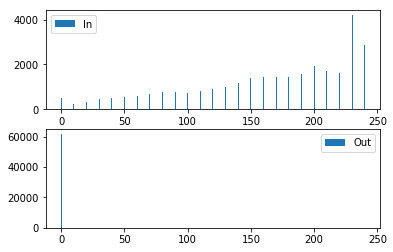

In [8]:
folder_stat('./data/5_ready/train/')

## Train some CNN

In [9]:
def load_dataset(dirname):
    in_data = []
    out_data = []
    prefixes = [fname[:-7] for fname
                in glob.glob(os.path.join(dirname, '*_in.png'))
                #in glob.glob('./data/5_ready/train/12147373-0005_*in.png')
               ]
    random.shuffle(prefixes)
    for prefix in prefixes:
        in_data.append(numpy.array(Image.open(prefix + '_in.png')))
        out_data.append(numpy.array(Image.open(prefix + '_out.png')))
    in_data = numpy.asarray(in_data).astype('float32') / 255.0
    out_data = numpy.asarray(out_data).astype('float32') / 255.0
    return (numpy.expand_dims(in_data, -1),
            numpy.expand_dims(out_data, -1))

train = load_dataset('/notebook/data/5_ready/train/')
test = load_dataset('/notebook/data/5_ready/test/')
print(train[0].shape, train[1].shape)
print(test[0].shape, test[1].shape)

(14, 256, 256, 1) (14, 256, 256, 1)
(14, 256, 256, 1) (14, 256, 256, 1)


In [26]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    first_conv_n = 3
    inputs = Input(train[0].shape[1:])
    conv1 = Conv2D(first_conv_n, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(first_conv_n, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(first_conv_n * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(first_conv_n * 2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(first_conv_n * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(first_conv_n * 4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv5 = Conv2D(first_conv_n * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv5 = Conv2D(first_conv_n * 8, (3, 3), activation='relu', padding='same')(conv5)

    up7 = concatenate([Conv2DTranspose(first_conv_n * 4, (2, 2), strides=(2, 2), padding='same')(conv5), conv3], axis=3)
    conv7 = Conv2D(first_conv_n * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(first_conv_n * 4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(first_conv_n * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(first_conv_n * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(first_conv_n * 2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(first_conv_n, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(first_conv_n, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(first_conv_n, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = get_unet()
model.summary()
model.fit(train[0],
          train[1],
          epochs=20,
          validation_split=0.1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_174 (Conv2D)              (None, 256, 256, 3)   30          input_13[0][0]                   
____________________________________________________________________________________________________
conv2d_175 (Conv2D)              (None, 256, 256, 3)   84          conv2d_174[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D)  (None, 128, 128, 3)   0           conv2d_175[0][0]                 
___________________________________________________________________________________________

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 12 samples, validate on 2 samples
Epoch 1/20
12/12 [==============================] - 1s - loss: -0.3460 - dice_coef: 0.3460 - val_loss: -0.4383 - val_dice_coef: 0.4383
Epoch 2/20
12/12 [==============================] - 0s - loss: -0.3461 - dice_coef: 0.3461 - val_loss: -0.4384 - val_dice_coef: 0.4384
Epoch 3/20
12/12 [==============================] - 1s - loss: -0.3462 - dice_coef: 0.3462 - val_loss: -0.4385 - val_dice_coef: 0.4385
Epoch 4/20
12/12 [==============================] - 0s - loss: -0.3462 - dice_coef: 0.3462 - val_loss: -0.4386 - val_dice_coef: 0.4386
Epoch 5/20
12/12 [==============================] - 0s - loss: -0.3463 - dice_coef: 0.3463 - val_loss: -0.4388 - val_dice_coef: 0.4388
Epoch 6/20
12/12 [==============================] - 0s - loss: -0.3464 - dice_coef: 0.3464 - val_loss: -0.4389 - val_dice_coef: 0.4389
Epoch 7/20
12/12 [==============================] - 0s - loss: -0.3465 - dice_coef: 0.3465 - val_loss: -0.4390 - val_dice_coef: 0.4390
Epoch 8/20
1

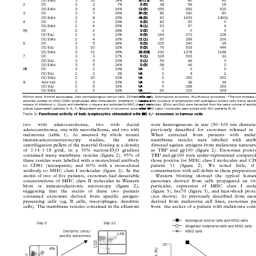

In [27]:
qq = Image.open('./data/5_ready/train/12147373-0005_2_in.png')
qq

'input_13'

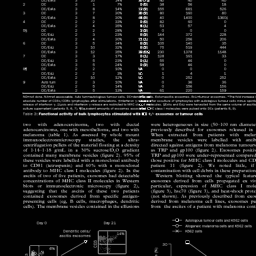

'conv2d_174'

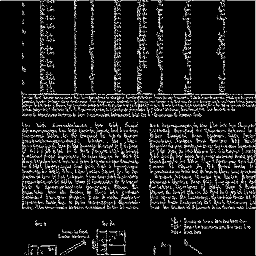

'conv2d_175'

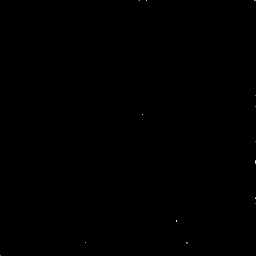

'max_pooling2d_36'

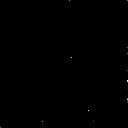

'conv2d_176'

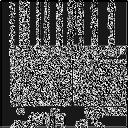

'conv2d_177'

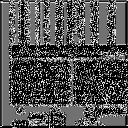

'max_pooling2d_37'

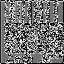

'conv2d_178'

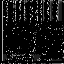

'conv2d_179'

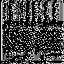

'max_pooling2d_38'

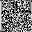

'conv2d_180'

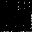

'conv2d_181'

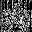

'conv2d_transpose_36'

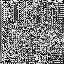

'concatenate_36'

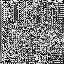

'conv2d_182'

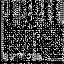

'conv2d_183'

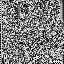

'conv2d_transpose_37'

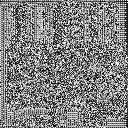

'concatenate_37'

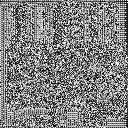

'conv2d_184'

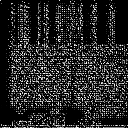

'conv2d_185'

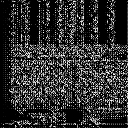

'conv2d_transpose_38'

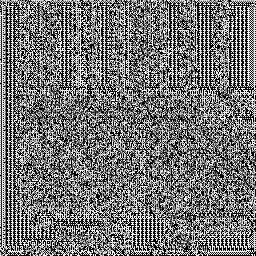

'concatenate_38'

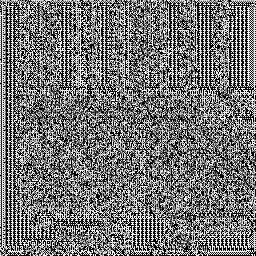

'conv2d_186'

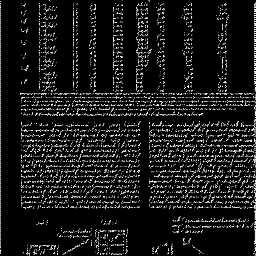

'conv2d_187'

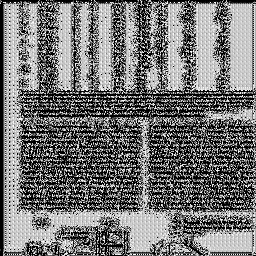

'conv2d_188'

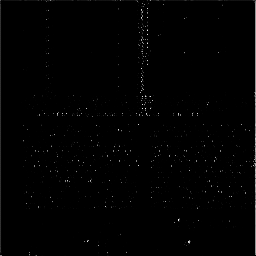

In [28]:
def make_layer_vis(model, layer_i):
    output_getter = K.function([model.layers[0].input],
                               [model.layers[layer_i].output])
    def _impl(img):
        inp = numpy.expand_dims(numpy.expand_dims(numpy.array(img), -1), 0)
        outp = output_getter([inp])[0]
        flat = outp[0, :, :, 0] #.reshape((outp.shape[1], outp.shape[2]*outp.shape[-1]))
        return Image.fromarray((flat*255).astype('uint8'))
    return _impl

def vis_layer(img, model):
    visualizers = [make_layer_vis(model, i)
                   for i in range(len(model.layers))]
    for layer, v in zip(model.layers, visualizers):
        display(layer.name)
        display(v(img))

vis_layer(qq, model)